In [1]:
using Pkg
Pkg.activate(".")
using locaTE
using OptimalTransport
using NPZ
using StatsBase
using SparseArrays
using ProgressMeter
using Plots
using NearestNeighbors
using Graphs
using GraphSignals
using Printf
using Base.Threads
using LinearAlgebra
using MultivariateStats
using NNlib
using Discretizers
using EvalMetrics
FIG_DIR = "./"
PLT_CELL = 500
Nq = 500
epfrac = 0.1

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated`
[ Info: Precompiling OptimalTransport [7e02d93a-ae51-4f58-b602-d97af76e3b33]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/backends.jl:43


0.1

In [23]:
# DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/Synthetic_2000/dyn-SW/dyn-SW-2000-2/"
# DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/Synthetic_1000/dyn-BFStrange/dyn-BFStrange-1000-1/"
# DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/Synthetic_10k/dyn-BFStrange/dyn-BFStrange-10000-1/"
DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/Synthetic_10k/dyn-SW/dyn-SW-10000-1/"
# DATA_PATH="/home/stephenz/stephenz/locaTE-paper/data/simulated/BoolODE/Curated/mCAD/mCAD-1000-1/"

"/home/stephenz/stephenz/locaTE-paper/data/simulated/Synthetic_10k/dyn-SW/dyn-SW-10000-1/"

In [24]:
using PyCall; ad = pyimport("anndata")
adata = ad.read_h5ad(joinpath(DATA_PATH, "anndata_paga.h5ad"))
# counts
X_raw = adata.X;
X = relu.(X_raw .- 10^(-0.5));
X_pca = adata.obsm.get("X_pca")
# extract clusters
clusters = map(x -> parse(Int64, string(x)), adata.obs[:louvain]);

In [25]:
A = zeros(Bool, size(X, 1), length(unique(clusters)))
for (i, j) in enumerate(clusters) A[i,j+1] = 1; end
# A = Array(I(size(X,1)));
A_norm_row = (A ./ sum(A; dims = 2))
A_norm_col = (A ./ sum(A; dims = 1));

In [26]:
coarsen_lin(x) = A_norm_col' * x
uncoarsen_lin(x) = A_norm_row * x
coarsen_quad(x) = A_norm_col' * x * A_norm_row;
uncoarsen_quad(x) = A_norm_row * x * A_norm_col';

In [27]:
C = adata.obsm.get("C")
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5*mean(C));

In [28]:
X_coarse = coarsen_lin(X);
C_coarse = coarsen_quad(adata.obsm.get("C"))
R_coarse = quadreg(ones(size(X_coarse, 1)), ones(size(X_coarse, 1)), C_coarse, 2.5*mean(C_coarse));

In [29]:
P = adata.obsm.get("P_velo_dot").todense()
Q = to_backward_kernel(P);
P_coarse = coarsen_quad(P)
Q_coarse = to_backward_kernel(P_coarse);

In [30]:
k = 3
# P, Q = R, R;
# k = 1

3

In [31]:
dpt = adata.obs[:dpt].to_numpy()
dpt_coarse = coarsen_lin(dpt);

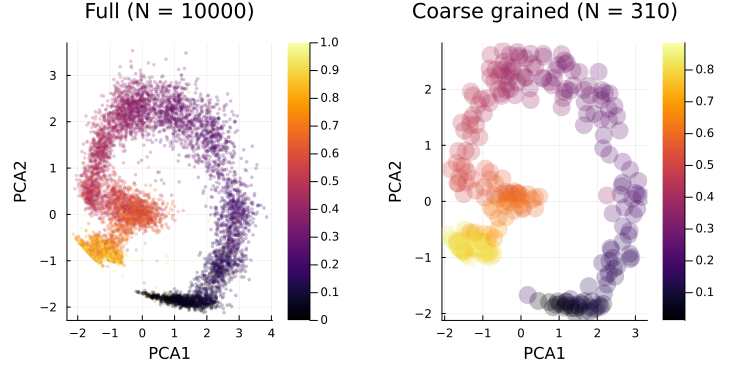

In [32]:
X_pca=adata.obsm.get("X_pca")
plt=plot(scatter(eachcol(X_pca[:, 1:2])...; alpha = 0.25, markersize = 2, marker_z = dpt, title = "Full (N = $(size(A, 1)))"),
    scatter(eachcol(coarsen_lin(X_pca)[:, 1:2])...; alpha = 0.25, markersize = 10, marker_z = dpt_coarse, title = "Coarse grained (N = $(size(A, 2)))"); markerstrokewidth = 0, legend = nothing, size = (1.5*PLT_CELL, 0.75*PLT_CELL), 
    xlabel = "PCA1", ylabel = "PCA2", margin = 5*Plots.mm)
savefig("switch_coarse_graining.pdf")
plt

In [33]:
function apply_locate(X, P, Q, R, k, A, L; symm = false, λ1 = 25, λ2 = 0.001)
    TE = estimate_TE(X, 1:size(X, 2), 1:size(X, 2), sparse(P^k), sparse((Q')^k), sparse(R); showprogress = true, wclr = true, clusters = A);
    G = fitsp(TE, L; λ1 = λ1, λ2 = λ2, maxiter = 50);
    # transfer entropy with undirected kernel is not necessarily symmetric
    G = if symm locaTE.symm_row(G, size(X, 2)) else G end
    G_static = reshape(mean(G; dims = 1), size(X, 2), size(X, 2));
    # CDF normalization
    A = reshape(maximum(G; dims = 1), size(X, 2), size(X ,2))
    G_cdf = locaTE.apply_cdf_norm(G, A);
    # CDF normalization for static
    G_static_cdf = locaTE.cdf_norm(G_static, G_static);
    G_cdf, G_static_cdf
end

apply_locate (generic function with 1 method)

In [34]:
G_cdf_coarse, G_static_cdf_coarse = apply_locate(X_coarse, P_coarse, Q_coarse, R_coarse, k, nothing, normalized_laplacian(adata.uns["paga"]["connectivities"].todense()); λ1 = 25.0)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


LoadError: DimensionMismatch: arguments must have the same number of rows

In [16]:
G_cdf_coarse2, G_static_cdf_coarse2 = apply_locate(X, P, Q, R, k, A, normalized_laplacian(adata.uns["paga"]["connectivities"].todense()); λ1 = 25.0)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:47
[ Info: ΔX = 4.595118507008981e-6, ΔZ = 0.00022154455488841013, ΔW = 0.0002833485015662704
[ Info: tr(X'LX) = 0.0485686550934041, 0.5|X-G|^2 = 1.0015480821329383, |X|1 = 105.33392111102998


([0.0 0.08162422384539834 … 0.005997457083873965 0.0; 0.0 0.0024248958687859714 … 0.011765950872617602 0.0; … ; 0.0 0.0 … 0.002946658564445647 0.0; 0.0 0.09548462990817248 … 0.023520501860730757 0.0], [0.0 0.9669216645355507 … 0.6251871785674699 0.08823648084012153; 0.4190277692040679 0.0 … 0.1461096478259222 0.8163236772628205; … ; 0.8533769302373718 0.26347961424700317 … 0.0 0.46905805138285905; 0.7919719051619583 0.7713013917117978 … 0.06266656915685545 0.0])

In [14]:
G_cdf, G_static_cdf = apply_locate(X, P, Q, R, k, nothing, construct_normalized_laplacian(X_pca, 25))

Progress: 100%|█████████████████████████████████████████| Time: 2:08:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
[ Info: ΔX = 4.811039637142871e-6, ΔZ = 0.0002975613604177703, ΔW = 0.000322305544812794
[ Info: tr(X'LX) = 1.1743869422802402, 0.5|X-G|^2 = 3.226565488909341, |X|1 = 3206.1914601086255
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


([0.0 0.04413939478734543 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.16072456481872852 … 0.010564560092586512 0.0; 0.0 0.15502352065519298 … 0.011361933504175806 0.0], [0.0 0.9572129256132991 … 0.6398360630379801 0.08218572446968889; 0.434393027214451 0.0 … 0.16281795675068636 0.8401446911669129; … ; 0.763507944577626 0.2895156495430189 … 0.0 0.49861701309799267; 0.6599767769866594 0.8152749101787222 … 0.07062835413330099 0.0])

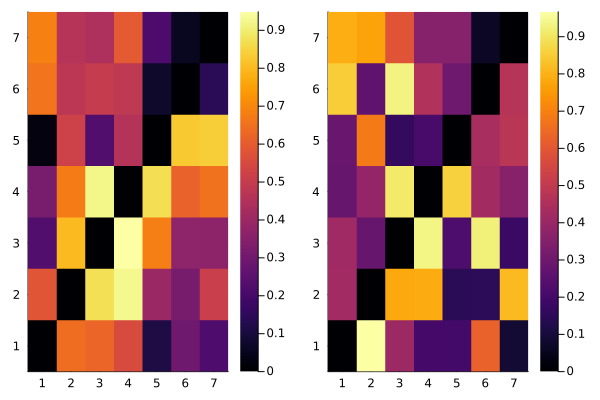

In [18]:
# plot(heatmap(G_static_cdf), heatmap(G_static_cdf_coarse), heatmap(G_static_cdf_coarse2))
plot(heatmap(G_static_cdf_coarse), heatmap(G_static_cdf_coarse2))

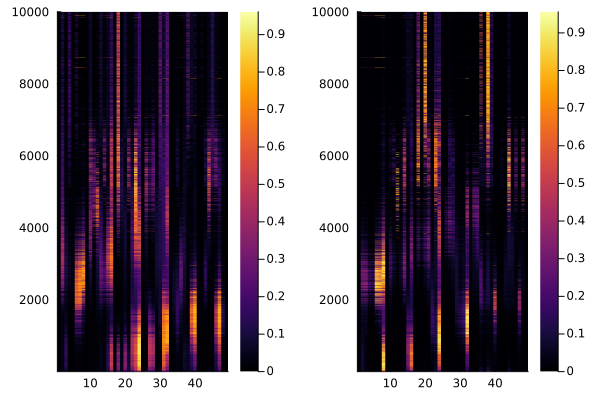

In [19]:
# plot(heatmap(G_cdf[sortperm(dpt), :]), heatmap((A * G_cdf_coarse)[sortperm(dpt), :]), heatmap((A * G_cdf_coarse2)[sortperm(dpt), :]))
plot(heatmap((A * G_cdf_coarse)[sortperm(dpt), :]), heatmap((A * G_cdf_coarse2)[sortperm(dpt), :]))

In [20]:
J = abs.(permutedims(npzread(joinpath(DATA_PATH, "J.npy")), [1, 3, 2]));
J_symm = locaTE.symm_row(reshape(J, :, size(X,2)*size(X,2)), size(X, 2))
J_static = (mean(J; dims = 1)[1, :, :] .> 0.05)
J_static_symm = locaTE.symm(J_static);

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


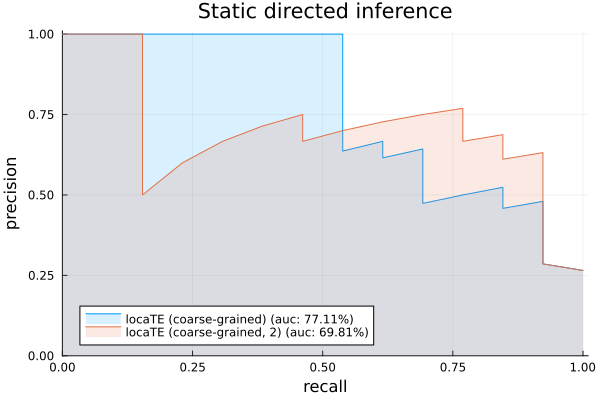

In [21]:
# plt1=prplot(vec(J_static), vec(G_static_cdf); label = "locaTE")
plt1=prplot(vec(J_static), vec(G_static_cdf_coarse); label = "locaTE (coarse-grained)")
prplot!(vec(J_static), vec(G_static_cdf_coarse2); label = "locaTE (coarse-grained, 2)")
plot!(plt1; title = "Static directed inference")

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


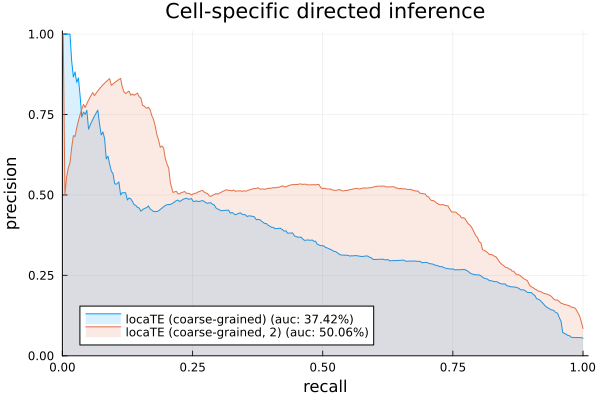

In [22]:
_J = reshape(abs.(J), :, size(X, 2) * size(X, 2))
# plt2 = prplot(
#     vec(R_coarse * coarsen_lin(_J)) .> 0.5,
#     vec(coarsen_lin(G_cdf));
#     label = "locaTE (manifold)",
# )
plt2=prplot(
    vec(R_coarse * coarsen_lin(_J)) .> 0.5,
    vec(G_cdf_coarse);
    label = "locaTE (coarse-grained)",
)
prplot!(
    vec(R_coarse * coarsen_lin(_J)) .> 0.5,
    vec(G_cdf_coarse2);
    label = "locaTE (coarse-grained, 2)",
)
plot!(plt2; title = "Cell-specific directed inference")

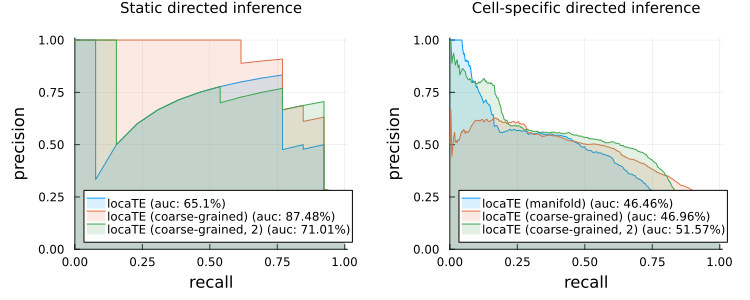

In [112]:
plt=plot(plt1, plt2; titlefontsize = 10, size = (750, 300), margin = 5*Plots.mm)
savefig(joinpath(FIG_DIR, "switch_coarse_graining_dir.pdf"))
plt

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


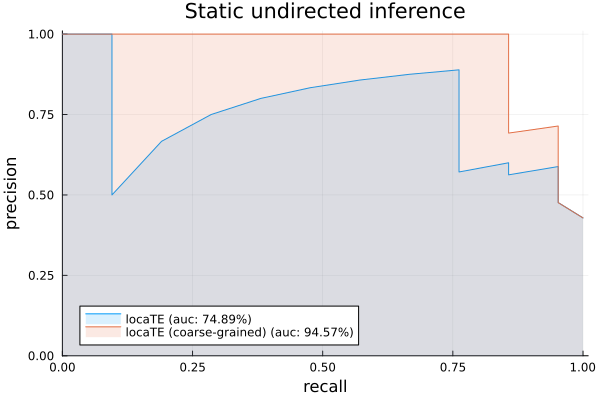

In [113]:
plt1=prplot(vec(J_static_symm), vec(locaTE.symm(G_static_cdf)); label = "locaTE")
prplot!(vec(J_static_symm), vec(locaTE.symm(G_static_cdf_coarse)); label = "locaTE (coarse-grained)")
plot!(plt1; title = "Static undirected inference")

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/args.jl:1148


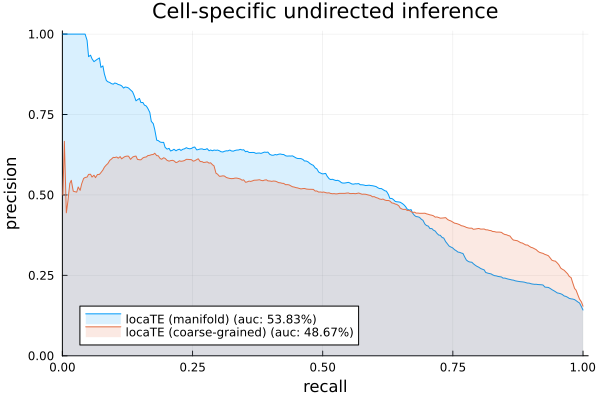

In [114]:
_J = locaTE.symm_row(reshape(abs.(J), :, size(X, 2) * size(X, 2)), size(X, 2))
plt2 = prplot(
    vec(R_coarse * coarsen_lin(_J)) .> 0.5,
    vec(coarsen_lin(locaTE.symm_row(G_cdf, size(X, 2))));
    label = "locaTE (manifold)",
)
prplot!(
    vec(R_coarse * coarsen_lin(_J)) .> 0.5,
    vec(locaTE.symm_row(G_cdf_coarse, size(X, 2)));
    label = "locaTE (coarse-grained)",
)
plot!(plt2; title = "Cell-specific undirected inference")

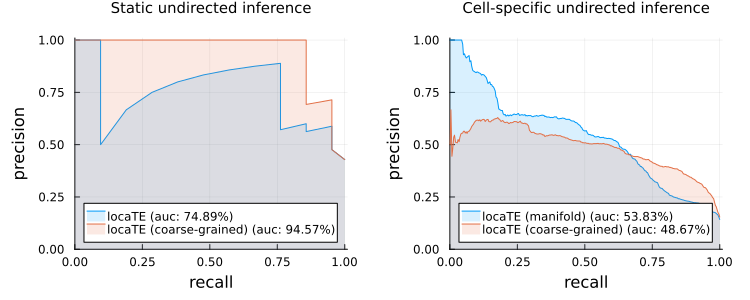

In [115]:
plt=plot(plt1, plt2; titlefontsize = 10, size = (750, 300), margin = 5*Plots.mm)
savefig(joinpath(FIG_DIR, "switch_coarse_graining_undir.pdf"))
plt